In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#Import Tree Models from scratch functions
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/TreeModelsFromScratch")

from DecisionTree import DecisionTree
from RandomForest import RandomForest
from SmoothShap import verify_shap_model, smooth_shap

In [44]:
# Import other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import imodels
from sklearn.tree import DecisionTreeRegressor
from copy import deepcopy

# Recreation of results from hierarchical shrinkage paper

Hierarchical Shrinkage: Improving the accuracy and interpretability of tree-based models <br>
[Link to paper](https://proceedings.mlr.press/v162/agarwal22b.html)


>HS is integrated into the imodels package [imodels](github.com/csinva/imodels) (Singh et al., 2021) with an sklearn compatible API. Experiments for reproducing the results here can be found at [imodels-experiments](github.com/Yu-Group/imodels-experiments)

## Figure 2: Toy univariate regression problems

Code for simulation taken from this [notebook](https://github.com/Yu-Group/imodels-experiments/blob/master/notebooks/shrinkage/03_shrinkage_example.ipynb)

In [13]:
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [76]:
def plot_sim(n=50, std=1, reg_param=0, show=True, linear_data=False, return_curves=False, use_imodels=True, ax=None):
    
    if ax == None:
        ax = plt.axes()
    
    np.random.seed(13)

    if linear_data:
        def gt_func(X):
            return X
    else:
        def gt_func(X):
            return +1 * (X < 2) * (X < 1) + \
                   -0 * (X < 2) * (X > 1) + \
                   +1 * (X >= 2) * (X < 3) + \
                   +0 * (X >= 2) * (X > 3)

    # data to fit
    X = np.random.uniform(0, 4, n)
    X = np.sort(X)
    y = gt_func(X) + np.random.normal(0, 1, n) * std


    # data to plot
    X_tile = np.linspace(0, 4, 400)
    y_tile = gt_func(X_tile)

    #return X, y, X_tile, y_tile
    
    # for original plots use sklearn and imodels
    if use_imodels:
        m1 = DecisionTreeRegressor(random_state=1)  #, max_leaf_nodes=15)
        m1.fit(X.reshape(-1, 1), y)
        y_pred_dt = m1.predict(X_tile.reshape(-1, 1))

        mshrunk = imodels.HSTreeRegressor(deepcopy(m1), reg_param=reg_param)
        y_pred_shrunk = mshrunk.predict(X_tile.reshape(-1, 1))

    #use TreeModelsfromScratch package
    else:
        m1 = DecisionTree(treetype="regression", random_state=1)
        m1.fit(X.reshape(-1,1), y.reshape(-1,1))
        y_pred_dt = m1.predict(X_tile.reshape(-1,1))
        
        mshrunk = DecisionTree(treetype="regression", HShrinkage=True, HS_lambda=reg_param, random_state=1)
        mshrunk.fit(X.reshape(-1,1), y.reshape(-1,1))
        y_pred_shrunk = mshrunk.predict(X_tile.reshape(-1, 1))
    
    ax.plot(X, y, 'o', color='black', ms=4, alpha=0.5, markeredgewidth=0)    
    ax.plot(X_tile, y_tile, label='Groundtruth', color='black', lw=3)    
    ax.plot(X_tile, y_pred_dt, '-', label='CART', color="skyblue", alpha=0.5, lw=4)
    ax.plot(X_tile, y_pred_shrunk, label='hsCART', color='#ff4b33', alpha=0.5, lw=4)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()
    #dvu.line_legend(adjust_text_labels=False)
    if show == 'save':
        ax.savefig(f'gif/{reg_param}.svg')
    elif show == 'pass':
        pass
    elif show:
        ax.show()
    else:
        ax.close()

    if return_curves:
        return X, y, X_tile, y_tile, y_pred_dt, y_pred_shrunk

#     print('dt', export_text(m1, feature_names=['X']))
#     print('dt', export_text(mshrunk.estimator_, feature_names=['X']))

# plot_sim(n=100)

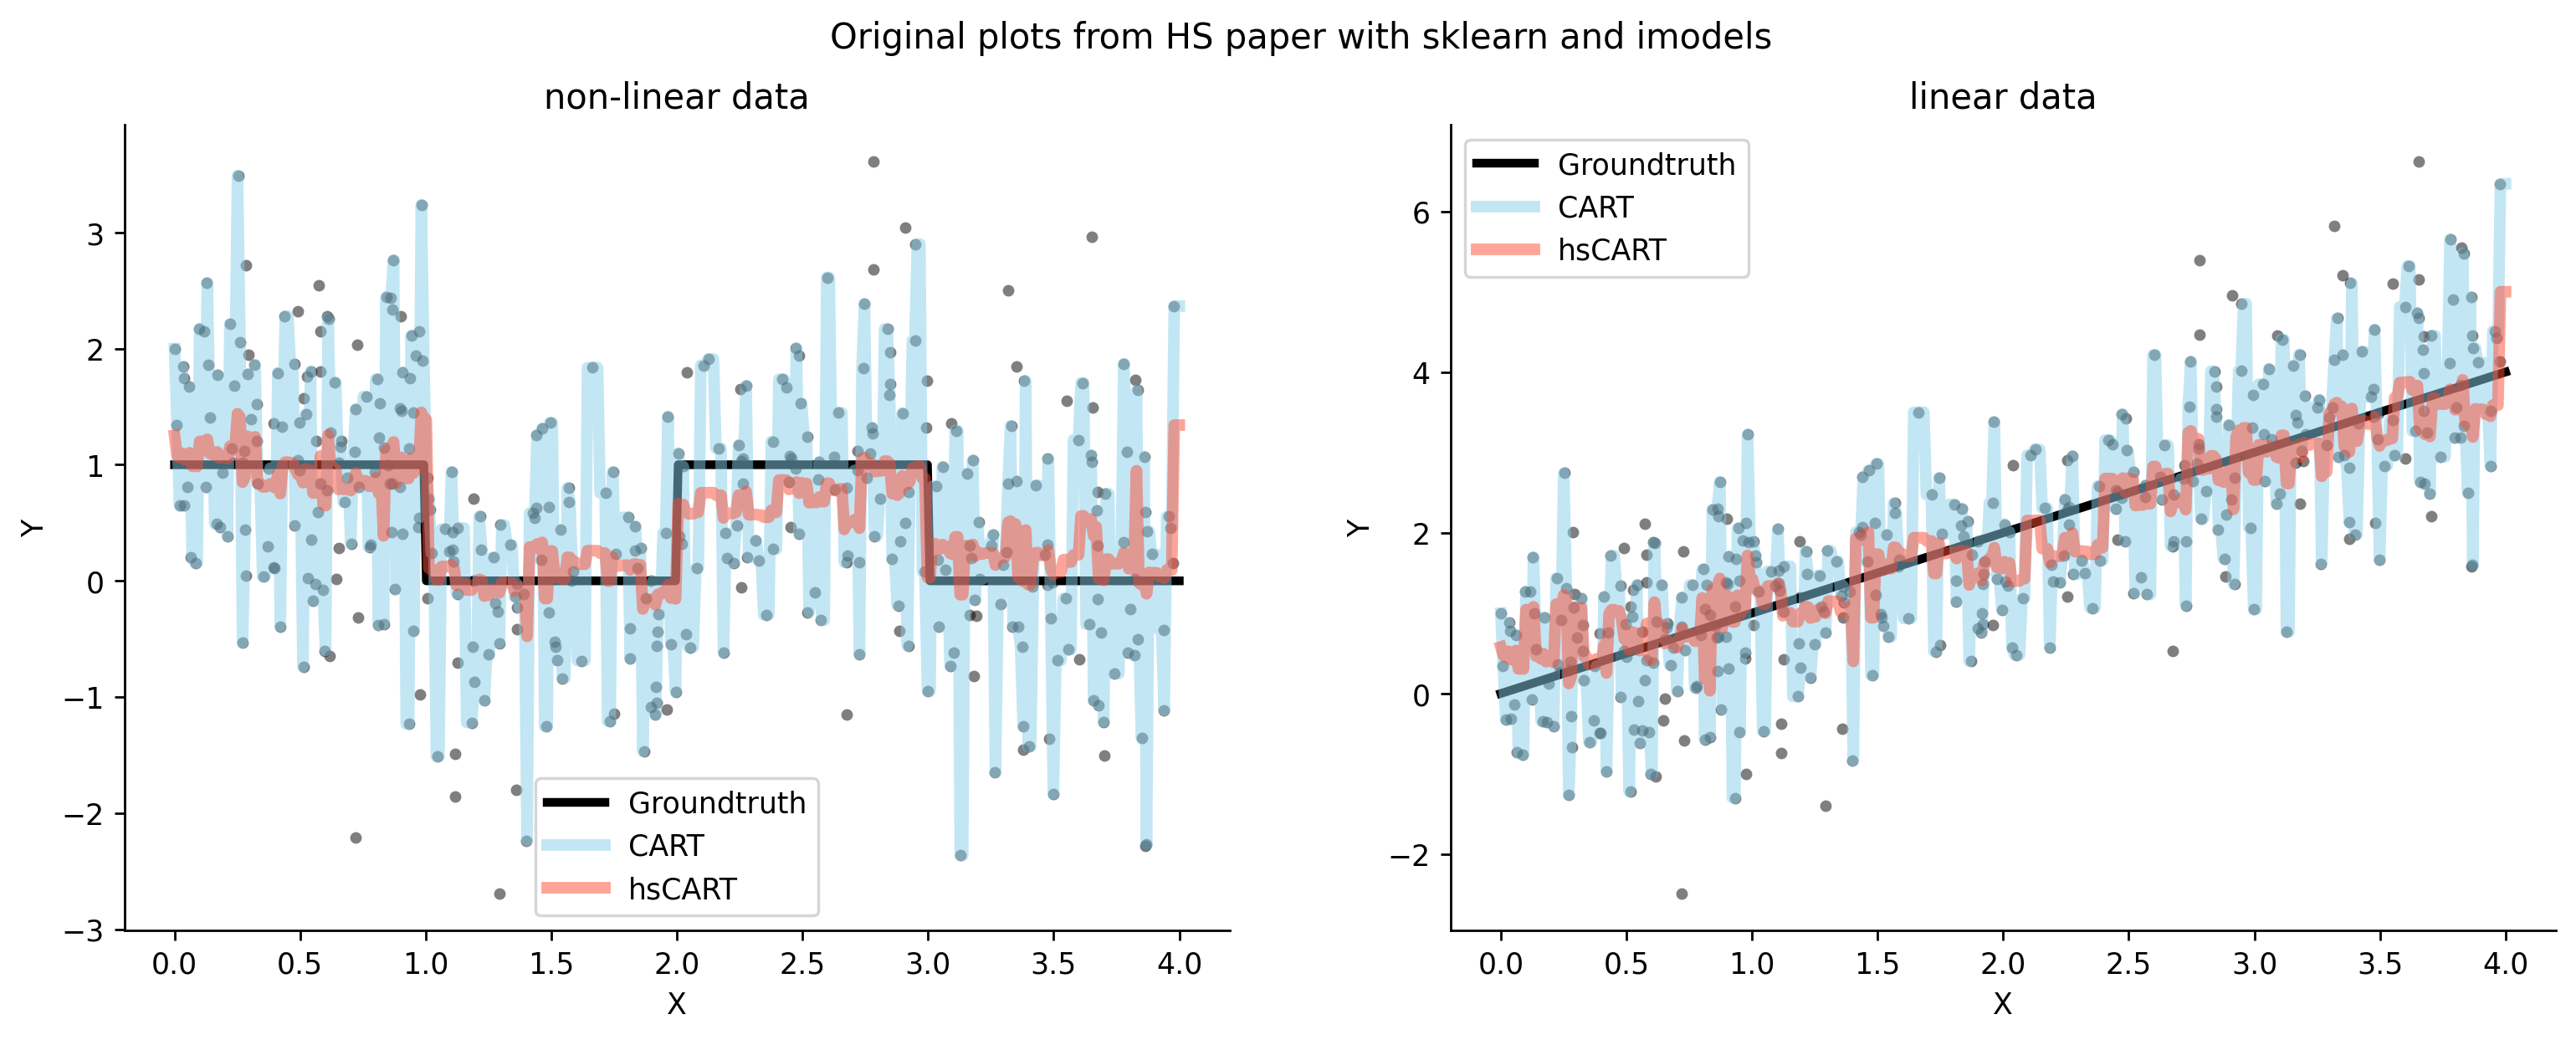

In [83]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("Original plots from HS paper with sklearn and imodels")
_, y_orig_lin, _, _, y_pred_dt_orig_lin, y_pred_shrunk_orig_lin = plot_sim(n=400, std=1, reg_param=100, show='pass', ax=axs[0], return_curves=True)
_, y_orig_nonlin, _, _, y_pred_dt_orig_nonlin, y_pred_shrunk_orig_nonlin = plot_sim(n=400, std=1, reg_param=50, linear_data=True, show='pass', ax=axs[1], return_curves=True)

axs[1].set_title('linear data')
axs[0].set_title('non-linear data');

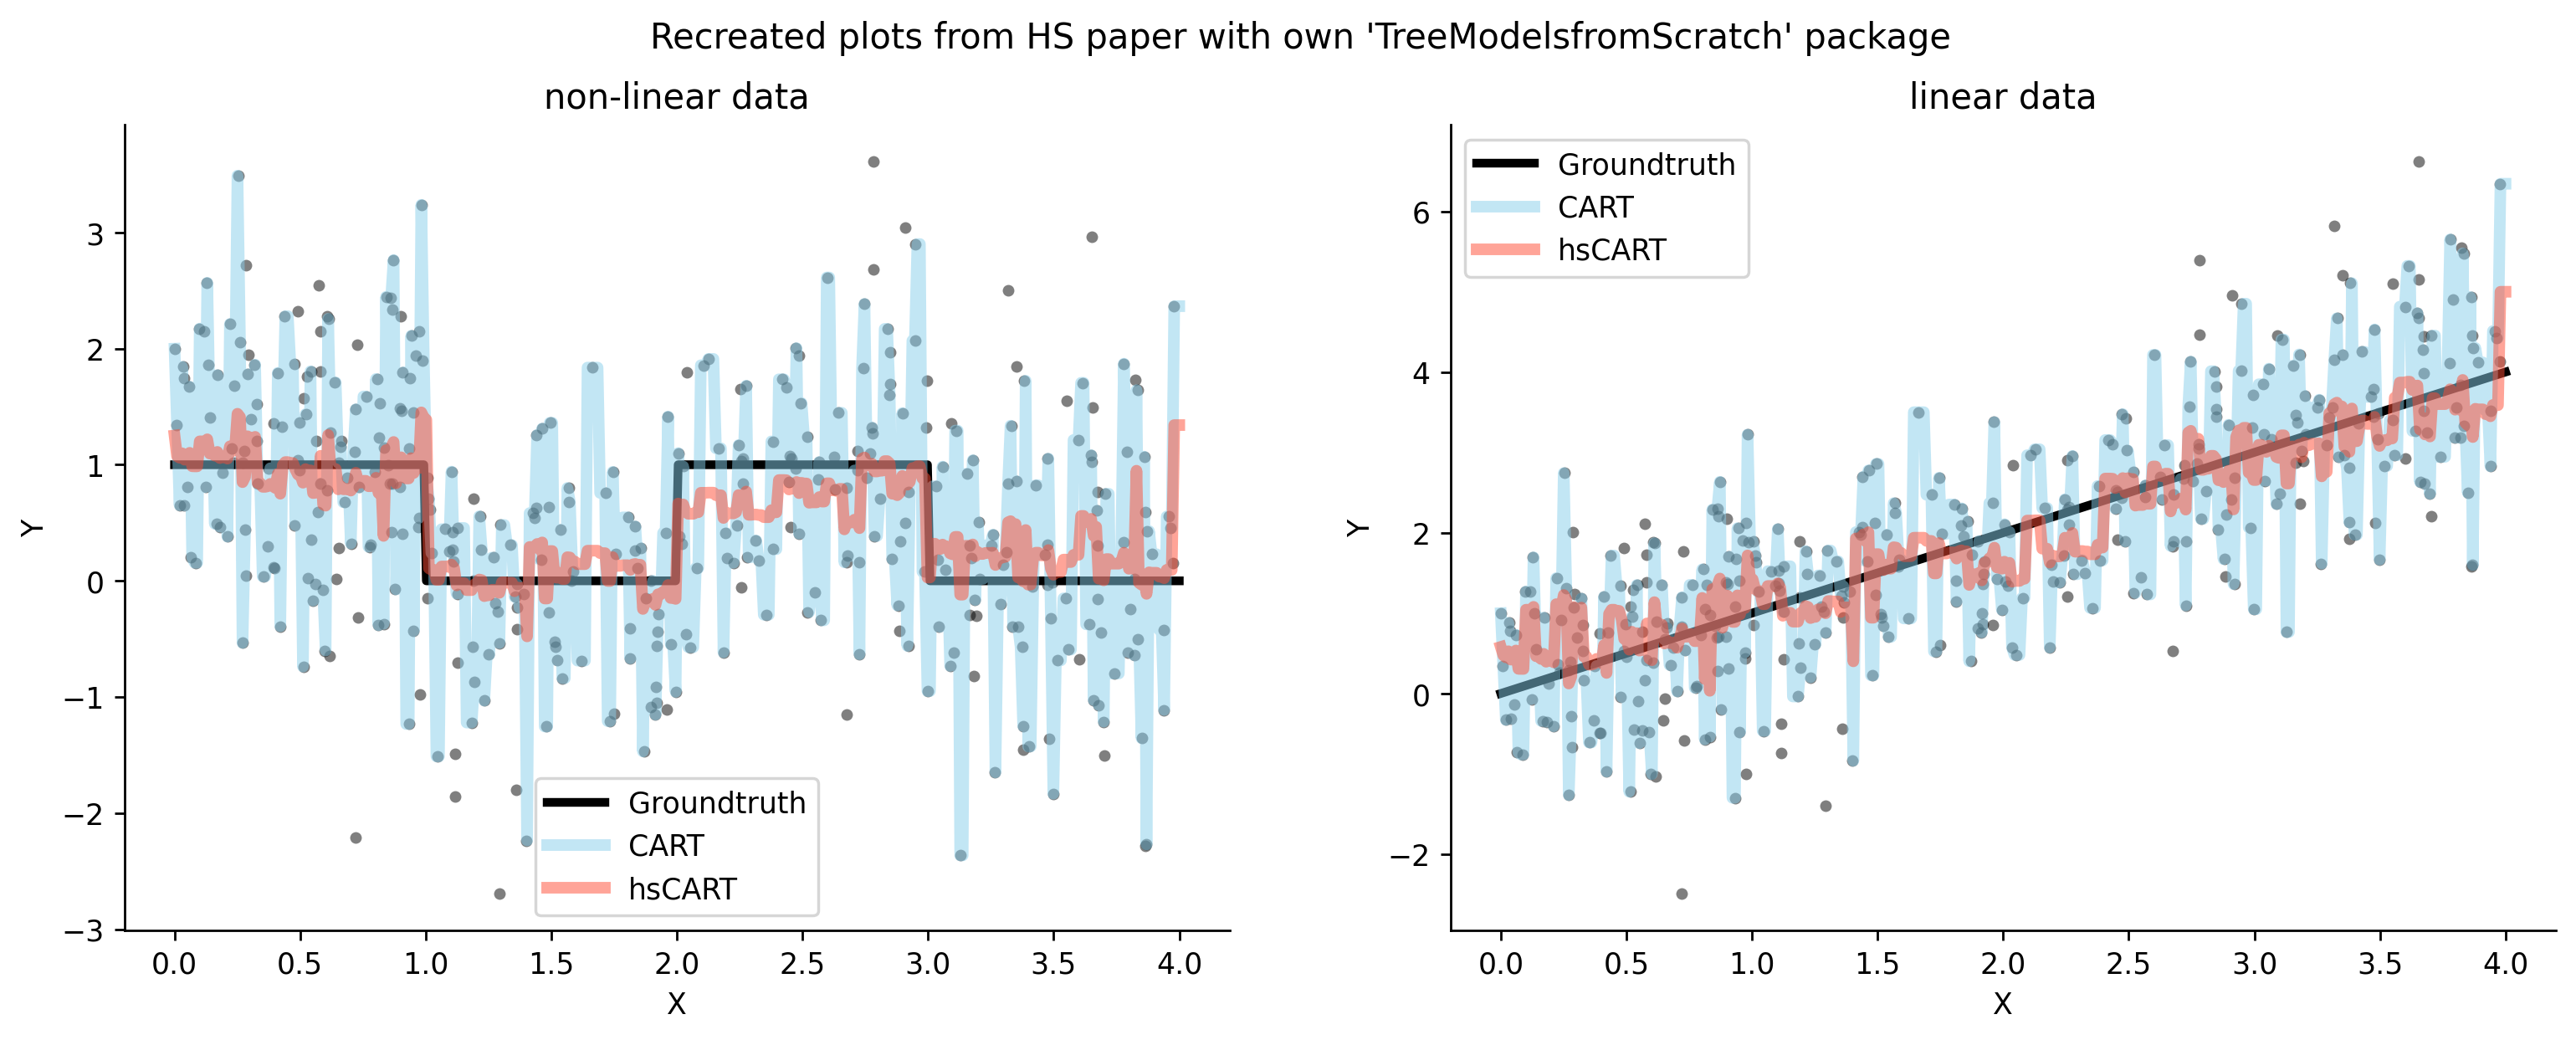

In [84]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
fig.suptitle("Recreated plots from HS paper with own 'TreeModelsfromScratch' package")

_, y_scra_lin, _, _, y_pred_dt_scra_lin, y_pred_shrunk_scra_lin = plot_sim(n=400, std=1, reg_param=100, use_imodels=False, show='pass', ax=axs[0], return_curves=True)
_, y_scra_nonlin, _, _, y_pred_dt_scra_nonlin, y_pred_shrunk_scra_nonlin = plot_sim(n=400, std=1, reg_param=50, use_imodels=False, linear_data=True, show='pass', ax=axs[1], return_curves=True)

axs[1].set_title('linear data')
axs[0].set_title('non-linear data');

The plots seem to be identical (or at least very close). But to make sure the predictions/ model performance is indeed close, we will compare the different arrays and compute MSE scores for the original paper and the scratch models.

In [85]:
from sklearn.metrics import mean_squared_error

In [90]:
np.array_equal(y_scra_lin, y_orig_lin)

True

In [91]:
np.array_equal(y_pred_dt_scra_lin, y_pred_dt_orig_lin)

True

In [92]:
np.array_equal(y_pred_dt_scra_nonlin, y_pred_dt_orig_nonlin)

True

In [97]:
print("MSE CART sklearn:", mean_squared_error(y_scra_lin, y_pred_dt_orig_lin))
print("MSE CART scratch:", mean_squared_error(y_scra_lin, y_pred_dt_scra_lin))

MSE CART sklearn: 1.8691503121023338
MSE CART scratch: 1.8691503121023338


In [99]:
np.array_equal(y_pred_shrunk_scra_lin.round(8), y_pred_shrunk_orig_lin.round(8))

True

In [100]:
np.array_equal(y_pred_shrunk_scra_nonlin.round(8), y_pred_shrunk_orig_nonlin.round(8))

True

In [101]:
print("MSE hsCART sklearn:", mean_squared_error(y_scra_lin, y_pred_shrunk_orig_lin))
print("MSE hsCART scratch:", mean_squared_error(y_scra_lin, y_pred_shrunk_scra_lin))

MSE hsCART sklearn: 1.0940734057905461
MSE hsCART scratch: 1.0940734057905461


The predictions/ MSE scores for both cases are identical for both packages

## Figure X